<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<a><img src='pics/banner.PNG'/></a>
</div>
<div>
<a href=''><img src='pics/miw.PNG'/></a>
<em>Author: Jeroen Boogaard</em>
</div>
</a>

<h1>Practicum SQL met <a href="https://geopandas.org/en/stable/index.html">GeoPandas</a></h1>
<img src="pics/geopandas_icon.png" width="40%" height="40%"/>

<h2>Environment Variables</h2>

In [70]:
import os
os.environ['export PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] ='notebook'
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

In [133]:
!(pip list | grep geopandas) || pip install geopandas

geopandas                     0.12.1


<h2>Imports<h2>

In [71]:
from pyspark import SparkContext as sc
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
import pyspark.sql
import pandas as pd
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot
import numpy as np

<h2>Data Visualization</h2>

<h3>Extract</h3>

In [72]:
data_dir = "../geo/ref-nuts-2021-01m/"

euPath = data_dir + "NUTS_RG_01M_2021_3035_LEVL_1.json"
gdf = gpd.read_file(euPath)

<h3>Transform</h3>

In [73]:
gdf.crs = "EPSG:3035"
gdfBen = gdf[(gdf.CNTR_CODE == "BE") | (gdf.CNTR_CODE == "NL") | (gdf.CNTR_CODE == "LU")]
gdfCrsBen = gdfBen.to_crs("EPSG:3857")
gdfNl = gdf[gdf.CNTR_CODE == "NL"]
gdfCrsNl = gdfNl.to_crs("EPSG:3857")

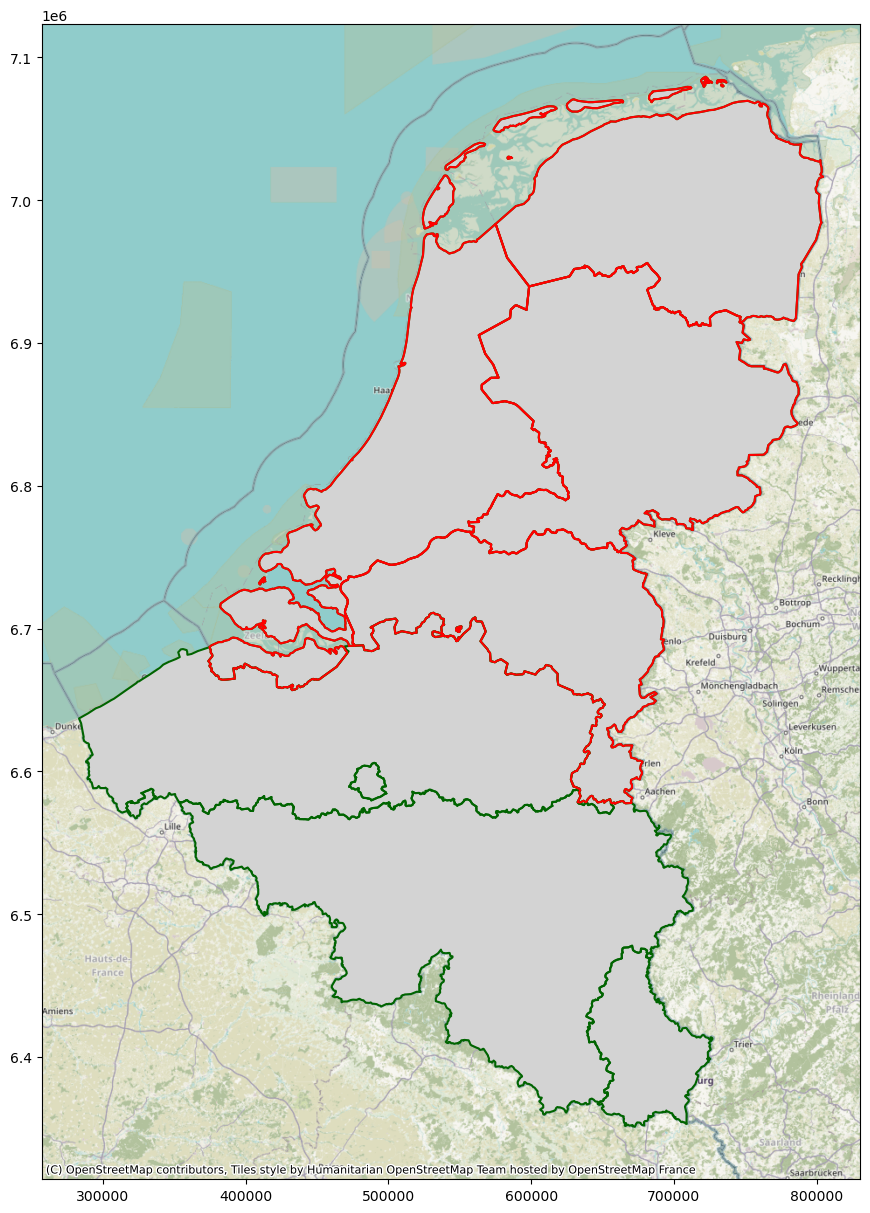

In [74]:
ax = gdfCrsBen.plot(figsize=(20,15), color="lightgray")

# Grenzen Benelux landen
gdfCrsBen.boundary.plot(color="darkgreen", ax=ax)

# Provincies Nederland
gdfCrsNl.boundary.plot(color="red", ax=ax)

# add background map by OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.HOT)

**Ingezoomed op de Benelux en Nederland met Provinciegrenzen**

<h3>Transform</h3>

<h2>PySpark</h2>

Load

In [75]:
eurCsvFile = "../csv/countries_europe.csv"
euCsvFile = "../csv/european_union.csv"
eurCodesCsvFile = "../csv/country-codes.csv"

In [76]:
# Create a Spark Session
spark = SparkSession.builder.appName('SQL').getOrCreate()

In [77]:
# Create Spark dataframe from csvfile
eurDf = spark.read.csv(eurCsvFile, inferSchema=True, header=True)
eurDf.printSchema()

root
 |-- zoom: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- abbreviation: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- ISO numeric: integer (nullable = true)
 |-- land area km: double (nullable = true)
 |-- population: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- continent: string (nullable = true)



In [78]:
# Create a view
eurDf.createOrReplaceTempView('countries')

**query op het dataframe via <i>methods</i>**

In [121]:
eurDf.select("Code").show(10)

+----+
|Code|
+----+
| UKR|
| FRA|
| ESP|
| SWE|
| DEU|
| FIN|
| NOR|
| POL|
| ITA|
| GBR|
+----+
only showing top 10 rows



**<i>SQL</i> query op het dataframe**

In [120]:
countriesQuery = """
    SELECT Code
    FROM countries
"""

eurCodes = spark.sql(countriesQuery)
eurCodes.show(10)

+----+
|Code|
+----+
| UKR|
| FRA|
| ESP|
| SWE|
| DEU|
| FIN|
| NOR|
| POL|
| ITA|
| GBR|
+----+
only showing top 10 rows



In [122]:
eurDf.select("Code").show(10)

+----+
|Code|
+----+
| UKR|
| FRA|
| ESP|
| SWE|
| DEU|
| FIN|
| NOR|
| POL|
| ITA|
| GBR|
+----+
only showing top 10 rows



<h3>Exercise 1</h3>
<p>
Maak op dezelfde manier dataframes euDf en eurCodesDf aan door het importeren vanuit de csv-files
</p>

In [123]:
euDf = spark.read.csv(euCsvFile, inferSchema=True, header=True)

In [126]:
euDf.show()

+----+-----------+-------------------+
|Code|       Name|       Member-Since|
+----+-----------+-------------------+
| AUT|    Austria|1995-01-01 00:00:00|
| BEL|    Belgium|1958-01-01 00:00:00|
| BGR|   Bulgaria|2007-01-01 00:00:00|
| HRV|    Croatia|2013-07-01 00:00:00|
| CYP|     Cyprus|2004-05-01 00:00:00|
| CZE|    Czechia|2004-05-01 00:00:00|
| DNK|    Denmark|1973-01-01 00:00:00|
| EST|    Estonia|2004-05-01 00:00:00|
| FIN|    Finland|1995-01-01 00:00:00|
| FRA|     France|1958-01-01 00:00:00|
| DEU|    Germany|1958-01-01 00:00:00|
| GRC|     Greece|1981-01-01 00:00:00|
| HUN|    Hungary|2004-05-01 00:00:00|
| IRL|    Ireland|1973-01-01 00:00:00|
| ITA|      Italy|1958-01-01 00:00:00|
| LVA|     Latvia|2004-05-01 00:00:00|
| LTU|  Lithuania|2004-05-01 00:00:00|
| LUX| Luxembourg|1958-01-01 00:00:00|
| MLT|      Malta|2004-05-01 00:00:00|
| NLD|Netherlands|1958-01-01 00:00:00|
+----+-----------+-------------------+
only showing top 20 rows



<h3>Exercise 2a</h3>
<p>
    Maak een <u>join</u> tussen <u>euDf</u> en <u>eurCodesDf</u> via kolom <u>Code</u> en <u>ISO3166-1-Alpha-3</u> 
</p>

In [ ]:
# Oplossing

<h3>Exercise 2b</h3>

<h4>Gegeven</h4>

<p>De dataset gdf bevat tweeletterige landcodes die je ook kunt terugvinden in de dataset <u>eurCodesDf</u></>

In [134]:
gdf.CNTR_CODE.tolist()[:10]

['CY', 'DE', 'CH', 'FR', 'BG', 'DE', 'EL', 'EL', 'DE', 'BE']

<h4>Gevraagd</h4>

<h4>Oplossing</h4>

**References**
<ul>
    <li>        
        <a href="https://towardsdatascience.com/pyspark-and-sparksql-basics-6cb4bf967e53">Pyspark SQL basics</a>       
    </li>
    <li>
        <a href="https://ec.europa.eu/eurostat/web/main/home">Eurostat</a>
    </li>
</ul>    